# Exchange Coupling

## Objective

In this new notebook I will analyze the data from PIMC simulations with the objective of computing the exchange function. The first cells will contain the same information as in PIMC Vectorized code, as the same constants and voltages must be defined. 
later, we will define the methods 
   - ParityOfCrossings
   - NumberOfCrossings
that will count the parity and number of crossings of each path. Finally , we plot NumberOfCrossings vs Path action, where expect to obtain a random linear deviation. The expected slope should be proportional to the exchange coupling

### Set-Up Notebook

In [1]:
%matplotlib notebook
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import linregress
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

# RC - params . Better plots
def SetPlotParams():
    '''
     Inputs:
     Return:
    '''
    plt.rcParams.update({'font.size': 25})
    plt.rc("text", usetex = True)
    plt.rc("font", family = "serif")
    plt.rcParams['figure.subplot.hspace'] = 0.3
    plt.rcParams['figure.subplot.wspace'] = 0.1
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['axes.formatter.limits'] = -3 , 3
    plt.rc('xtick.major', pad = 1)
    plt.rc('ytick.major', pad = 1)
    plt.rcParams['axes.labelpad'] = 15
    plt.rcParams['axes.formatter.use_mathtext'] = False
    plt.rcParams['figure.autolayout'] = True
    # plt.rcParams['figure.figsize'] =  8.3, 6.8
    plt.rcParams['figure.figsize'] =  6.8, 8.3
# %%
SetPlotParams()


### List of Constants

In [30]:
## List of Constants



"""Parameters, units: ueV, nm, ns"""
print('Setting initial constants')
#N = 80 #time_steps and number of tried changes during one sweep.
num_path = 1000 #number of sweeps
print('num_paths = ', num_path)

#beta = 0.1 # imaginary total time? (/hbar?)
tau = 10 ** (-6) #ns
print('tau = ', tau, '(ns)')



interaction = 1 # Turn on/off electron-electron interaction (1 or 0)
h= np.array([1,.7,.08])
print('Displacement vector (h) =', h , 'nm')

eec = 1.23*10**5
print('Electron-electron coupling constant (eec) =', eec, 'ueV')
me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
print('me = ', repr(np.round(me,9)), 'ueV*ns^2/nm^2' )
mass = 1 # Effective mass on/off

if mass == 1:
        meff= 0.2 * me #effective electron mass in Silicon
        ml = 0.98 * me #effective mass in longitudinal k-direction
        mt = 0.19 * me #effective mass in transverse k-direction
        mx = mt #effective mass in x-direction
        my = mt #effective mass in y-direction
        mz = ml #effective mass in z-direction
        m = np.array([mx,my,mz])
        print('Effective mass vector (m) = ', m,'*me' )
else:
        print('No Mass')

pot_step = 3 * 10**6 #ueV - Si/SiO2 interfac
print('Step voltage(pot_step) = ', pot_step,' $ueV$' )
        
        
# %%

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon

w = 4000/hbar
q = 10**6 # ueV
lamda = 0.5 * hbar**2 / me
r_0 = np.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV/nm - Electric field in z direction

# %%
Kb = 86.173324#mueV K−1
# a=10
slope = E_z
V = pot_step
x_0 = 1.5*r_0

# V_field = V_hrl

print('Lattice constant (a)=', a, 'nm')
print('Temperature -', hbar/(Kb*6000*tau), 'K')

# HRL_Potential = 'old_UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
HRL_Potential = 'UNSW4_1st withBG TEST ephiQWM for VX1_1V UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
print('Setting HRL potential VX1 =1V' )
print('----------------------------- \n' )

Setting initial constants
num_paths =  1000
tau =  1e-06 (ns)
Displacement vector (h) = [1.   0.7  0.08] nm
Electron-electron coupling constant (eec) = 123000.0 ueV
me =  5.686e-06 ueV*ns^2/nm^2
Effective mass vector (m) =  [1.08034e-06 1.08034e-06 5.57228e-06] *me
Step voltage(pot_step) =  3000000  $ueV$
Lattice constant (a)= 0.543 nm
Temperature - 1.2730157652964624 K
Setting HRL potential VX1 =1V
----------------------------- 



In [32]:


'''Define grid and HRL potential'''
xs = np.load(HRL_Potential)['xs']
ys = np.load(HRL_Potential)['ys']
zs = np.load(HRL_Potential)['zs']
ephi = 10**6 * np.load(HRL_Potential)['ephi']

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'linear') #options 'linear' , 'nearest'

def ee(path1,path2):
    return(eec/dist(path1,path2))

def dist(path1,path2):
    minus = path1-path2
    return np.sqrt(minus[0,:]**2 + minus[1,:]**2 + minus[2,:]**2)

def V_hrl(path):
    return interpolate(path.T) + V_step(path[2,:])

V_field = V_hrl
print('HRL')

V_field = V_hrl
interaction = 1

def KineticEnergy(MassVec,path):
    '''Computes kinetic energy of path of an electron path
       inputs: MassVec(3*1-array)
               path(3*N-array)
       return: Energy vector(N-array)
    '''
    Rpath = np.roll(path,-1,(1))
    return (.5/(4*tau**2))*np.matmul(np.transpose(MassVec),(Rpath-path)**2)


def V_step(z_path):
    zero_arr = np.zeros((3,len(z_path)))
    zero_arr[2,:] = z_path
    return(V / (np.exp(-a*z_path) + 1) + interpolate(zero_arr.T))


def find_action(path1,path2):
    '''Computes the action given two electron paths
       inputs: Path1 , Path2: 3*N-arrays
       outputs: Action(real)
    '''
    V_interaction = interaction * np.sum(ee(path1,path2))
    
    s1 = tau*KineticEnergy(m,path1)
    s2 = tau*KineticEnergy(m,path2)
    
    s1 = np.sum(s1) + tau * np.sum(V_field(path1))# + V_interaction
    s2 = np.sum(s2) + tau * np.sum(V_field(path2))# + V_interaction
    
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s

def findPathsAction(Paths1,Paths2):
    S = []
    for NP in range(len(Paths1[:,0,0])):
        s = find_action(Paths1[NP,:,:],Paths2[NP,:,:])
        S.append(s)
    return np.array(S)
    


HRL


In [33]:
# vec = np.linspace(0,4,5)
# np.roll(vec, -1)

<IPython.core.display.Javascript object>


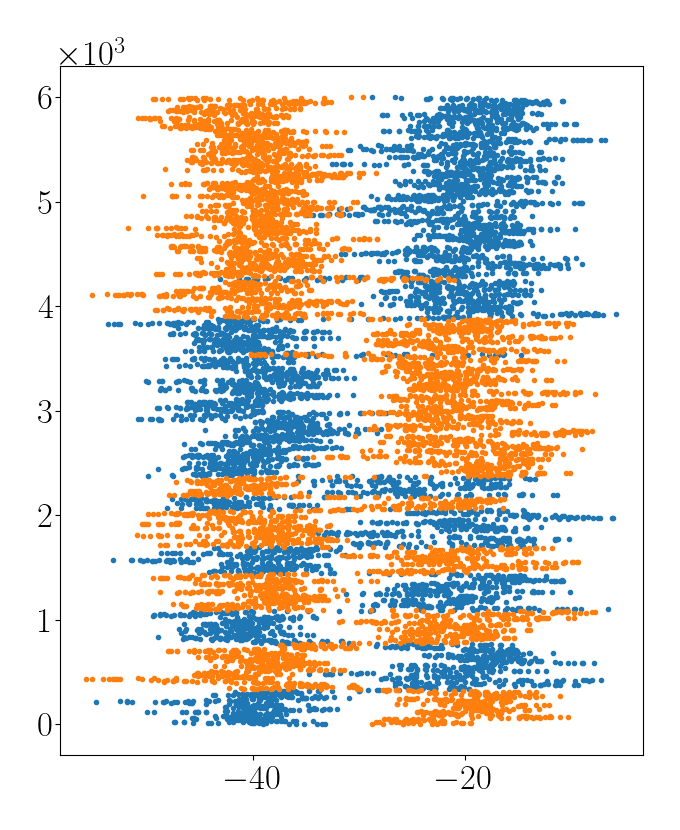

4


(20, 3, 6000)

In [61]:


# PP1 = np.load('Paths/HundredPaths1.npy')
# PP2 = np.load('Paths/HundredPaths2.npy')
# SS = findPathsAction(PP1,PP2)

# P1 = np.load('Paths/150Paths1.npy')
# P2 = np.load('Paths/150Paths2.npy')
# Permutations  = np.load('Paths/150Permutations.npy' )
# S_mean = np.load('Paths/150S_mean.npy')
# S_std = np.load('Paths/150S_std.npy')


P1 = np.load('Paths/101VPaths1.npy')
P2 = np.load('Paths/101VPaths2.npy')
Permutations  = np.load('Paths/101VPermutations.npy' )
S_mean = np.load('Paths/101VS_mean.npy')
S_std = np.load('Paths/101VS_std.npy')


# rows = 2
# cols = 2
# fig, axarr = plt.subplots(rows,cols)
# for i in range(rows):
#     for j in range(cols):
#         NP = np.random.randint(len(P1[:,0,0]))
#         axarr[i,j].plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '-')
#         axarr[i,j].plot(P2[NP,0,:], range(len(P1[NP,0,:])),':')


fig, ax = plt.subplots(1,1) 
# for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
# # for NP in range(len(P1[:,0,0])):
NP = 4
print(NP)
ax.plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '.')
ax.plot(P2[NP,0,:], range(len(P1[NP,0,:])),'.')


np.shape(P1)

<IPython.core.display.Javascript object>


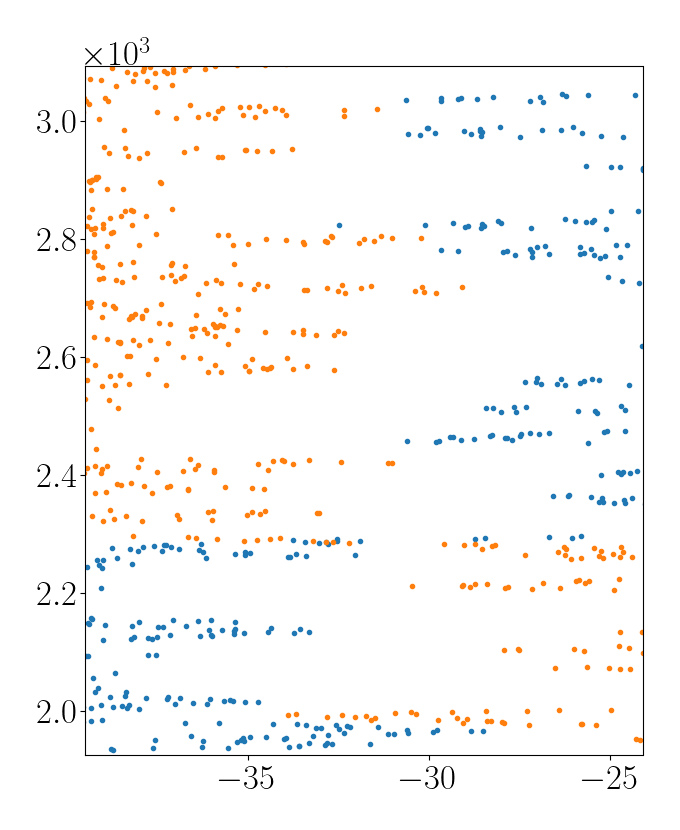

6


In [64]:
# Psym1 = np.load('Paths/10CroPaths1.npy')
# Psym2 = np.load('Paths/10CroPaths2.npy')

# PermSym  = np.load('Paths/10CroPermutations.npy' )
# S_meanSym = np.load('Paths/10CroS_mean.npy')
# S_stdSym = np.load('Paths/10CroS_std.npy')


Psym1 = np.load('Paths/10Paths1.npy')
Psym2 = np.load('Paths/10Paths2.npy')

PermSym  = np.load('Paths/10Permutations.npy' )
S_meanSym = np.load('Paths/10S_mean.npy')
S_stdSym = np.load('Paths/10S_std.npy')


# # rows = 2
# cols = 2
# fig, axarr = plt.subplots(rows,cols)
# for i in range(rows):
#     for j in range(cols):
#         NP = np.random.randint(len(P1[:,0,0]))
#         axarr[i,j].plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '-')
#         axarr[i,j].plot(P2[NP,0,:], range(len(P1[NP,0,:])),':')


fig, ax = plt.subplots(1,1) 
# for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
# # for NP in range(len(P1[:,0,0])):
NP = 6
print(NP)
ax.plot(Psym1[NP,0,:], range(len(P1[NP,0,:])) , '.')
ax.plot(Psym2[NP,0,:], range(len(P1[NP,0,:])),'.')


In [67]:
PP1  = np.concatenate((P1, Psym1), axis = 0)
PP2  =np.concatenate((P2, Psym2), axis = 0)
SS  = np.concatenate((S_mean, S_meanSym), axis = 0)
PermP = np.concatenate((Permutations, PermSym), axis = 0)
np.shape(Psym1)
np.shape(PP1)

# np.save('Paths/101VPaths1', PP1 )
# np.save('Paths/101VPaths2', PP2 )
# np.save('Paths/101VPermutations', PermP )
# np.save('Paths/101VS_mean', SS )


(30, 3, 6000)

In [66]:
np.shape( np.shape(np.concatenate((P1, Psym1), axis = 0)))

(3,)

In [73]:
S_std

array([29.94530071, 82.50035437, 48.08634758, 70.22215675, 39.83004718,
       44.39400751, 28.54357216, 37.78838105, 52.42802361, 63.23563594,
       87.13768977, 47.00103501, 72.43787028, 41.5291228 , 60.86092954,
       57.3010853 , 28.84882277, 53.46290769, 64.5544756 , 38.02230466,
       40.18845807, 37.4324936 , 44.87273884, 84.49156286, 56.14645523,
       23.40353442, 47.89175303, 55.28399166, 86.19229293, 44.49289251,
       47.66370753, 53.00638406, 48.71495856, 40.29194304, 65.27902449,
       34.61845079, 70.77126957, 58.65293184, 54.08006382, 58.58688769,
       23.74678356, 69.06983013, 28.71677639, 42.1846635 , 47.00440211,
       99.75048961, 39.43193427, 39.07283215, 48.93954666, 71.96407174,
       78.63477913, 65.70158164, 31.90880061, 49.05788955, 60.67399886,
       53.15283792, 48.60974552, 36.09678864, 68.57665082, 81.69639413,
       55.36406403, 42.90552353, 48.71471653, 51.61088429, 60.64552673,
       60.18056896, 83.37292437, 69.26416059, 48.68294313, 41.95

In [68]:
def ParityOfCrossings(Paths1,Paths2):
    '''
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return:Parity of crossings for each pair of paths

    '''
    return -(2*(NumberOfCrossings(Paths1,Paths2)%2)-1) 


def NumberOfCrossings(Paths1,Paths2):
    ''' Returns 
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return: Number of crossings for each pair of paths

    ''' 
    Sq = np.sign(Paths1[:,0,:]-Paths2[:,0,:])
    BitFunc = np.absolute(Sq[:,1:]-Sq[:,:-1])/2
    return np.sum(BitFunc, axis=1)
    

<IPython.core.display.Javascript object>


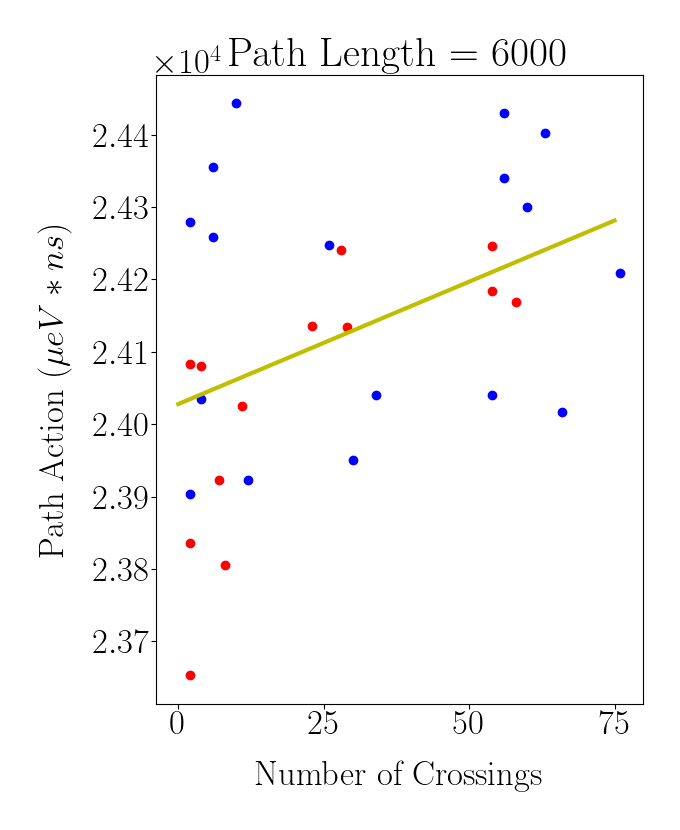

array([3.38133125])

In [74]:
Parity = ParityOfCrossings(PP1,PP2)
Parity =PermP
fig, ax = plt.subplots(1,1) 
SS = findPathsAction(PP1,PP2)
# Even = Parity[Parity == 1]
# Odd = Parity[Parity == -1]
# S_even = S_mean[Parity == 1]
# S_odd = S_mean[Parity == -1]

crossings = NumberOfCrossings(PP1,PP2)

# ax.scatter(crossings[Parity == 1], S_mean[Parity == 1] , 'r')
# ax.scatter(crossings[Parity == -1], S_mean[Parity == -1] , 'b')

x = np.linspace(0,75,75)
# x = np.linspace(0,20,61)
# [len(crossings[Parity == 1]) ,len(S_mean[Parity == 1] )]
# S_mean[Parity == 1]


ax.plot(crossings[Parity == 1], SS[Parity == 1] , 'bo')
ax.plot(crossings[Parity == -1], SS[Parity == -1] , 'ro')



# ax.plot(crossings[:-10], SS[:-10] , 'ro')
# ax.plot(crossings[-10:-5], SS[-10:-5] , 'bo')
# ax.plot(crossings[-5:], SS[-5:] , 'go')
# print(np.mean(S_even) , np.mean(S_odd) )


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
crossings = crossings.reshape(-1,1)

regression_model = LinearRegression()
# # Fit the data(train the model)
reg  = regression_model.fit(crossings, SS)
# # Predict

# crossings

reg.intercept_

ax.plot(x, reg.intercept_ + x*reg.coef_ , 'y-' )
# # Model initialization

# # y_predicted = regression_model.predict(x)
ax.set_title('Path Length = 6000')
ax.set_xlabel('Number of Crossings')
ax.set_ylabel('Path Action $(\\mu eV *ns)$')
reg.coef_

In [57]:
print((1.05935468/6000)*1000 , 'neV')


0.17655911333333332 neV


In [58]:
print('Mean Energy ', 2.4*10**4/6000, 'ueV')

Mean Energy  4.0 ueV


In [171]:
NumberOfCrossings(PP1,PP2)
ParityOfCrossings(PP1,PP2)
findPathsAction(PP1,PP2)
print('Action: Mean , STD  (Distribution is not taken into account yet)')
print(np.mean(findPathsAction(P1,P2)),' , ',np.std(findPathsAction(P1,P2)))
print('Number of Crossings: Mean , STD')
print(np.mean(NumberOfCrossings(P1,P2)),' , ',np.std(NumberOfCrossings(P1,P2)))
print('Count of Odd Crossings')
print(sum(ParityOfCrossings(P1,P2)==-1))
print('Count of Even Crossings')
print(sum(ParityOfCrossings(P1,P2)==1))

Action: Mean , STD  (Distribution is not taken into account yet)
24505.662799671612  ,  277.4112068507387
Number of Crossings: Mean , STD
36.84375  ,  11.43489553679875
Count of Odd Crossings
79
Count of Even Crossings
81


In [7]:
ParityOfCrossings(P1,P2)==-1
oddargs = np.argwhere(ParityOfCrossings(P1,P2)==-1)
P1_odd = P1[oddargs[:,0],:,:]
P2_odd = P2[oddargs[:,0],:,:]

In [8]:

DeltaS = np.sum(findPathsAction(P1_odd,P2_odd))-np.sum(findPathsAction(P1,P2))
J = -DeltaS
DeltaS/100

-2550.649314350469

In [137]:
np.sum(findPathsAction(P1_odd,P2_odd))/4049.071020506987

np.sum(findPathsAction(P1,P2))/4049.071020506987
print((1/(tau*1000))*np.log(37/(100-37)), 'THz' )

1477.200473746 THz


In [10]:
13.46582018

4049.788395017617

In [11]:
np.mean(findPathsAction(P1,P2))

4049.071020506987

In [116]:
#findPathsAction(P1_odd,P2_odd)/hbar #- np.sum(-findPathsAction(P1,P2)/hbar)
S = []
Paths1 = P1_odd
Paths2 = P2_odd
for NP in range(len(Paths1[:,0,0])):
    s = find_action(Paths1[NP,:,:],Paths2[NP,:,:])
    S.append(s)
S

[4052.974506848366,
 4159.324574175614,
 4071.175768081528,
 3966.9201355694795,
 4036.261775397248,
 4084.6819273186793,
 4061.1140239702727,
 4013.1009338009558,
 4088.0769977308128,
 4132.044903498997,
 4002.905463304566,
 4034.6228332941996,
 4074.6178383983483,
 4000.3694214826824,
 4061.8601467737562,
 4038.7602777620764,
 4001.421096431257,
 4183.64785324981,
 4077.704344690454,
 4056.3312322430656,
 4018.045149713453,
 4024.8770549255805,
 4000.793401266676,
 4014.2968522308624,
 4027.800749858919,
 4042.4403425453816,
 4026.4250472434087,
 4026.4274442071423,
 4043.428041888344,
 4033.8171840349996,
 4032.518600148977,
 4009.81601763331,
 4004.246544776336,
 4102.144557485469,
 4114.1285442979715,
 4087.797155279048,
 4035.2518740937453]

In [32]:
np.shape(P1_odd)


TypeError: can't multiply sequence by non-int of type 'float'

<IPython.core.display.Javascript object>


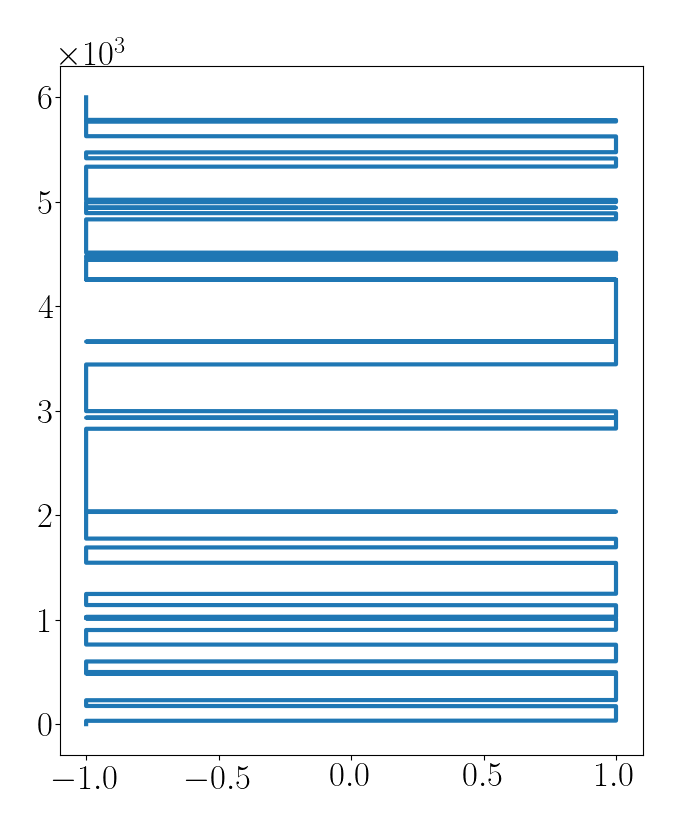

1.0

In [59]:
NP =15

fig, ax = plt.subplots(1,1)

A = np.sign(P1[NP,0,:]-P2[NP,0,:])
# A = P1[NP,0,:]-P2[NP,0,:]
ax.plot( A  , range(len(P2[NP,0,:])))
ParityOfCrossings(P1,P2)[20]

<IPython.core.display.Javascript object>


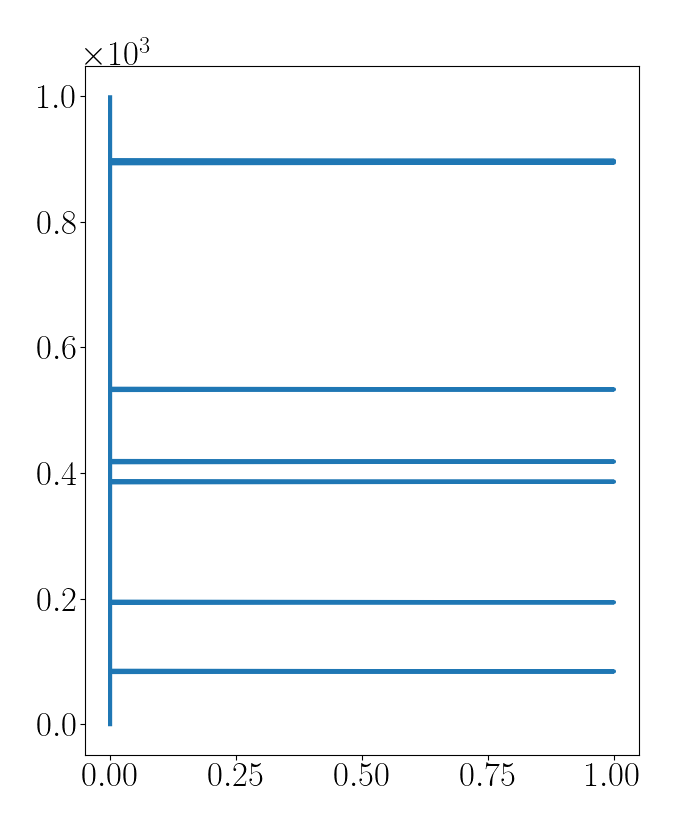

In [24]:
fig, ax = plt.subplots(1,1)

A = np.sign(P1[NP,0,:]-P2[NP,0,:])
ax.plot( np.absolute(A[1:]-A[:-1])/2  , range(len(P2[NP,0,:])-1))



In [25]:
sum(np.absolute(A[1:]-A[:-1])/2)

7.0